# Implementing Shor's algorithm

Here, we are only interested in the part of the algorithm solving the period-finding function.


## To hand out

1. A **report** with your answers in a **PDF FILE** (made out of LaTeX, libreoffice, ...)
  * Math and text answers
  * The code for the circuits
  * Screenshot of figures/circuits
  * python answers and results of runs
  * *etc*
  
2. **This notebook**
  * as a runnable script



But first, some libraries to load (nothing to modify here)

In [ ]:
import numpy as np
from math import pi, gcd
try:
    from qiskit import *
    from qiskit_aer import AerSimulator,StatevectorSimulator
    from matplotlib.pyplot import plot,show
except:
    ! python -m pip install matplotlib pylatexenc
    ! python -m pip install qiskit qiskit-aer
from qiskit import *
from qiskit.circuit import *
from qiskit_aer import AerSimulator
from qiskit.circuit.library import *
from qiskit.quantum_info.operators import Operator
from qiskit.compiler import transpile
from qiskit.transpiler import PassManager
from scipy import optimize
from matplotlib.pyplot import plot,show
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # Makes the images look nice


## A few useful functions

- `nat2bl` : from a natural number to a list of `0` and `1` (low-end bit on the right)
- `nat2bs` : from a natural number to a string such as `"010010011"`
- `bl2bs` : from a list to a string
- ... and all of the functions in the other direction.

In [ ]:
def nat2bl(pad,n):
    if n == 0 :
        return [0 for i in range(pad)]
    elif n % 2 == 1:
        r = nat2bl(pad-1,(n-1)//2)
        r.append(1)
        return r
    else:
        r = nat2bl(pad-1,n//2)
        r.append(0)
        return r

for i in range(16):
    print(nat2bl(5,i))

[0, 0, 0, 0, 0]
[0, 0, 0, 0, 1]
[0, 0, 0, 1, 0]
[0, 0, 0, 1, 1]
[0, 0, 1, 0, 0]
[0, 0, 1, 0, 1]
[0, 0, 1, 1, 0]
[0, 0, 1, 1, 1]
[0, 1, 0, 0, 0]
[0, 1, 0, 0, 1]
[0, 1, 0, 1, 0]
[0, 1, 0, 1, 1]
[0, 1, 1, 0, 0]
[0, 1, 1, 0, 1]
[0, 1, 1, 1, 0]
[0, 1, 1, 1, 1]


In [293]:
def bl2nat(s): # prend une liste de bits 0 1 en entrée et renvoie le nombre correspondant
    if len(s) == 0:
        return 0
    else:
        a = s.pop()
        return (a + 2*bl2nat(s))

def bl2bs(l): # prends une liste avec des bits et renvoie une la chaine de caractères
    if len(l) == 0:
        return ""
    else:
        a = l.pop()
        return (bl2bs(l) + str(a))

def nat2bs(pad,i):# prends un nombre et le convertit en binaire en chaine de caractères 
    return bl2bs(nat2bl(pad,i))

def bs2bl(s): # prends un nombre binaire en chaine de caractères et le renvoie en binaire lsite
    l = []
    for i in range(len(s)):
        l.append(int(s[i]))
    return l

def bs2nat(s):# prends un nombre binaire en string et le renvoie en base 10 
    return bl2nat(bs2bl(s))


print(nat2bs(10,17))
print(bs2nat("0011010"))

0000010001
26


# 0 - Before anything else...

### Make sure you have done Part 1 on QPE


# 1 - Introduction

In this lab session we are going to code the heart of Shor's algorithm: the circuit making it possible to find the period of the function

$$
x \mapsto a^x mod N.
$$

We first need to code the oracle computing the multiplication modulo, then to combined it with QPE.

**Objective** : Only to convince yourself that the number we are looking for can be recovered from the final distribution.

**Prerequisite** : To have finished the Jupyter Notebook called `TP-QPE`

Let's go.

# 2 - Oracle synthesis

The function $f : x\mapsto (a^p\cdot x)~mod~N$ is a bijection of $\{0...N-1\}$ to $\{0...N-1\}$ if $a$ and $N$ are co-primes. 

In this case, we can consider $f$ as a unitary operator acting on a Hilbert space of dimension $N$.
One can then consider $f$ as a unitary acting on a register of qubits, provided that $N$ is a power of $2$.

This is a bit limited : we want to be able to consider arbitrary numbers $N$. We then instead consider the function:
$$
Mult_{a^p~mod~N} : x\mapsto 
\left\{
\begin{array}{ll}
(a^p\cdot x)~mod~N & \text{si }x < N
\\
x & \text{si} N \leq x < 2^n
\end{array}\right.
$$
provided that $N<2^n$.

This new function $Mult_{a^p~mod~N}$ is indeed a bijection of $\{0..2^n\}$: we are going to implement this one instead. Here, we are making something simple, using the automated circuit synthesis of QisKit. It is not the most efficient, but it is the easiest for our purpose.

To clarify what is expected, let us consider the code for $Mult_{2^3~mod~13}$, that is, $Mult_{8~mod~13}$. To store all of the numbers from $0$ to $12$ we need $4$ bits. The table for the operation $Mult_{8~mod~13}$ is as follows. We first write it using decimal numbers, then with the binary decomposition. Note how starting from $x=13$ we are just padding to complete to $15 = 2^4-1$.

```
| x  |  result  || x (binary) | result (binary) |
| -- | -------- || ---------- | --------------- |
| 0  |  0       || 0000       | 0000            |
| 1  |  8       || 0001       | 1000            |
| 2  |  3       || 0010       | 0011            |
| 3  |  11      || 0011       | 1011            |
| 4  |  6       || 0100       | 0110            |
| 5  |  1       || 0101       | 0001            |
| 6  |  9       || 0110       | 1001            |
| 7  |  4       || 0111       | 0100            |
| 8  |  12      || 1000       | 1100            |
| 9  |  7       || 1001       | 0111            |
| 10 |  2       || 1010       | 0010            |
| 11 |  10      || 1011       | 1010            |
| 12 |  5       || 1100       | 0101            |
| -- | --       || ----       | ----            |
| 13 | 13       || 1101       | 1101            |
| 14 | 14       || 1110       | 1110            |
| 15 | 15       || 1111       | 1111            |
```

The corresponding matrix is then

$$
\begin{array}{ccccccccccccc|ccc}
1&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0\\
0&0&0&0&0&1&0&0&0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&0&0&0&0&1&0&0&0&0&0\\
0&0&1&0&0&0&0&0&0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&0&1&0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&0&0&0&0&0&0&1&0&0&0\\
0&0&0&0&1&0&0&0&0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&0&0&0&1&0&0&0&0&0&0\\
0&1&0&0&0&0&0&0&0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&1&0&0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&0&0&0&0&0&1&0&0&0&0\\
0&0&0&1&0&0&0&0&0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&0&0&1&0&0&0&0&0&0&0\\\hline
0&0&0&0&0&0&0&0&0&0&0&0&0&1&0&0\\
0&0&0&0&0&0&0&0&0&0&0&0&0&0&1&0\\
0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&1\\
\end{array}
$$

The top-left block corresponds to the permutation matrix : $|0010\rangle$ is for instance sent to $|0011\rangle$ (i.e. $2$ is sent to $3$). The bottom-right block corresponds to the padding with identity, to build an unitary matrix defined on the whole space.


## Questions

### Q 2.1 Operator for the multiplication modulo.

- Complete the following code so that `M` is a matrix implementing the bijection $Mult_{a^p~mod~N}$.
- Test it with the code below it, with $a = 1, 3, 6, 11, 15$.

In [ ]:
def gateMult(a, p, N, n):
    nn = 2 ** n
    M = np.zeros((nn, nn), dtype=complex)
    ap_mod_N = pow(a, p, N)
    used_results = set()
    for x in range(nn):
        if x < N:
            result = (ap_mod_N * x) % N
            if result in used_results:
                print(f"Avertissement : Conflit détecté pour le résultat {result} lors du mappage de x = {x}")
                M[x][x] = 1  # Affecter 1 à la diagonale pour garder l'identité partielle
            else:
                M[result][x] = 1
                used_results.add(result)
        else:
            M[x][x] = 1  # Garder les valeurs en dehors de N inchangées
    # Vérifier que la matrice est unitaire avant de créer la porte
    if not np.allclose(np.dot(M, M.T.conj()), np.eye(nn), atol=1e-8):
        print("Matrice générée :")
        print(M)
        raise ValueError("La matrice générée n'est pas unitaire.")
    U = Operator(M)
    return UnitaryGate(U)


Testing with a = 1
Input : [0, 0, 1, 1] (= 3 en décimal)
Correct answer should be 3 * 1^4 mod 11 = 3
The circuit answer: 0011 (= 3 in decimal)

Testing with a = 3
Input : [0, 0, 1, 1] (= 3 en décimal)
Correct answer should be 3 * 3^4 mod 11 = 1
The circuit answer: 0001 (= 1 in decimal)

Testing with a = 6
Input : [0, 0, 1, 1] (= 3 en décimal)
Correct answer should be 3 * 6^4 mod 11 = 5
The circuit answer: 0101 (= 5 in decimal)

Testing with a = 11
Input : [0, 0, 1, 1] (= 3 en décimal)
Avertissement : Conflit détecté pour le résultat 0 lors du mappage de x = 1
Avertissement : Conflit détecté pour le résultat 0 lors du mappage de x = 2
Avertissement : Conflit détecté pour le résultat 0 lors du mappage de x = 3
Avertissement : Conflit détecté pour le résultat 0 lors du mappage de x = 4
Avertissement : Conflit détecté pour le résultat 0 lors du mappage de x = 5
Avertissement : Conflit détecté pour le résultat 0 lors du mappage de x = 6
Avertissement : Conflit détecté pour le résultat 0 lor

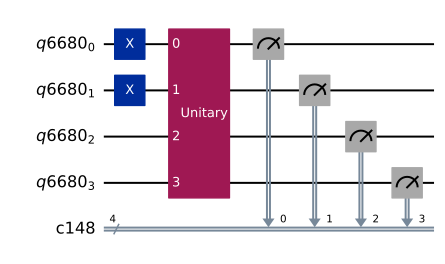

In [ ]:
x = 3
p = 4
N = 11
n = 4
a_values = [1, 3, 6, 11, 15]

for a in a_values:
    print(f"Tes avec a = {a}")

    phi = QuantumRegister(n)
    cphi = ClassicalRegister(n)
    qc = QuantumCircuit(phi, cphi)

    vl = nat2bl(n, x)
    print(f"Entrée {str(vl)} (= {x} en décimal)")
    vl.reverse()  
    for i in range(len(vl)):
        if vl[i] == 1:
            qc.x(phi[i])

    qc.append(gateMult(a, p, N, n), list(phi))
    qc.measure(phi, cphi)
    simulator = AerSimulator()
    job = simulator.run(qc, shots=1024)
    d = dict(job.result().get_counts(qc))

    assert(len(d) == 1)
    s = list(d.keys())[0]
    if x < N:
        expected = (x * (a ** p)) % N
        print(f"La répionse correcte devrait être {x} * {a}^{p} mod {N} = {expected}")
    else:
        print(f"On est plus grands que {N} qui devrait être l'indentité")
    print(f"La réponse du circuit {s} (= {bs2nat(s)} en décimale)\n")

qc.draw(output='mpl')


### Q 2.2 Size of generated circuit

Qiskit packages the circuit it makes out of the matrix inside a nice and clean box. What is the concrete size of the generated circuit ? Let us test it to see.

- TODO : modify the code below to compute the size of the circuits generated by QisKit for the following matrices:
  * `gateMult(3,3,2 ** 2,2)`
  * `gateMult(3,3,2 ** 3,3)`
  * `gateMult(3,3,2 ** 4,4)`

And if the runtime is not too daunting (stop if above 1 minute)

  * `gateMult(3,3,2 ** 5,5)`
  * `gateMult(3,3,2 ** 6,6)` 
  * `gateMult(3,3,2 ** 7,7)`
  
#### Report your code and answers in the separate report !

Pour 3 qubits, il y a 31 portes au total.
Détails des portes : {'rx': 16, 'ry': 9, 'cx': 6}

Configuration (a=3, p=3, N=4, n=2): 1 portes au total
Détails des portes : {'cx': 1}

Configuration (a=3, p=3, N=8, n=3): 109 portes au total
Détails des portes : {'rx': 55, 'ry': 34, 'cx': 20}

Configuration (a=3, p=3, N=16, n=4): 535 portes au total
Détails des portes : {'rx': 282, 'ry': 153, 'cx': 100}

Configuration (a=3, p=3, N=32, n=5): 2381 portes au total
Détails des portes : {'rx': 1240, 'ry': 697, 'cx': 444}

Configuration (a=3, p=3, N=64, n=6): 9838 portes au total
Détails des portes : {'rx': 5078, 'ry': 2892, 'cx': 1868}

Configuration (a=3, p=3, N=128, n=7): 39993 portes au total
Détails des portes : {'rx': 20576, 'ry': 11757, 'cx': 7660}



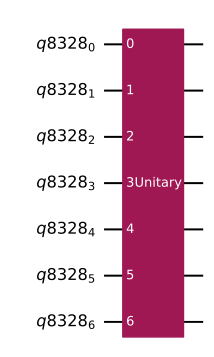

In [369]:
import time

n = 3
q = QuantumRegister(n)
qc = QuantumCircuit(q)

qc.h(q[0])                
qc.x(q[1])                
qc.ccx(q[0], q[1], q[2])  # Porte Toffoli contrôlée sur qubits 0 et 1 pour affecter le qubit 2
new_circ = transpile(qc, basis_gates=['id', 'ry', 'rx', 'cx'])
count = dict(new_circ.count_ops())
r = sum(count.values())
print(f"Pour {n} qubits, il y a {r} portes au total.")
print("Détails des portes :", count)
print()
qc.draw(output='mpl')

configs = [
    (3, 3, 2 ** 2, 2),
    (3, 3, 2 ** 3, 3),
    (3, 3, 2 ** 4, 4),
    (3, 3, 2 ** 5, 5),
    (3, 3, 2 ** 6, 6),
    (3, 3, 2 ** 7, 7)
]

# Test des différentes configurations et comptage des portes
for config in configs:
    a, p, N, n = config
    q = QuantumRegister(n)
    qc = QuantumCircuit(q)
    qc.append(gateMult(a, p, N, n), q)
    
    # Transpiler pour obtenir les portes élémentaires
    start_time = time.time()
    transpiled_circ = transpile(qc, basis_gates=['id', 'ry', 'rx', 'cx'])
    if (time.time() - start_time) > 60:
        print(f"Temps d'exécution trop long pour la configuration (a={a}, p={p}, N={N}, n={n})")
        break

    gate_count = dict(transpiled_circ.count_ops())
    total_gates = sum(gate_count.values())
    print(f"Configuration (a={a}, p={p}, N={N}, n={n}): {total_gates} portes au total")
    print("Détails des portes :", gate_count)
    print()
qc.draw(output='mpl')


In [370]:
r = 0
for k in count:
    r += count[k]
print(f"For {n} qubits there are {r} gates in total.")

For 7 qubits there are 31 gates in total.


### Q 2.3 Analysis

- What are the sizes of the generated circuits ?
- What is the complexity of the circuit size in term of number of qubits ?
- Can you explain why ?
- If it is doable for small `n`, is it realisitic for large sizes ?
- What alternate method could you suggest, with what potential drawbacks ?


#### Report your code and answers in the separate report !


# 3 - Plugging everything together : Shor

We are now ready to realize Shor's algorithm

## Questions

### Q 3.1 The circuit

Realize the circuit:
- Copy-paste the code of QPE, with 4 qbits of precision for `eig`
- Introduce our home-made unitary : choose 5 qbits pour `phi`
- Place `phi` in the state corresponding to the integer $1$ in decimal (beware of the position of the low-end bit)


Measurement results: {'1111': 205, '0001': 203, '1010': 21, '0000': 268, '1110': 115, '1011': 12, '0010': 106, '1101': 27, '0110': 16, '0011': 31, '0101': 8, '0111': 5, '1001': 7}


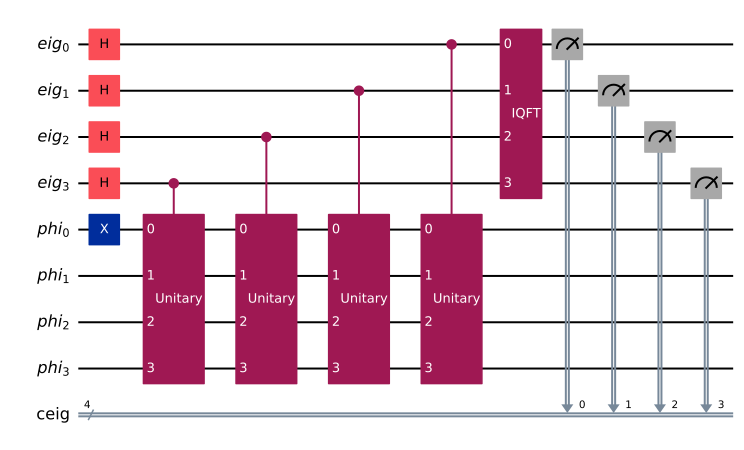

In [ ]:
a = 7 
p = 3 
N = 15 
n = 4  
size_eig = 4
eig = QuantumRegister(size_eig, name="eig")
phi = QuantumRegister(n, name="phi") 
ceig = ClassicalRegister(size_eig, name="ceig")
qc = QuantumCircuit(eig, phi, ceig)

qc.x(phi[0])  #  |0001> 
qc.h(eig)


for i in range(size_eig):
    power = 2 ** i  #  U^1, U^2, U^4, U^8
    controlled_mult_gate = gateMult(a, power, N, n).control(1)
    qc.append(controlled_mult_gate, [eig[size_eig - i - 1]] + list(phi))

qc.append(QFT(size_eig, inverse=True).to_gate(), eig)

qc.measure(eig, ceig)
qc.draw(output='mpl')
qc.draw(output='mpl')

simulator = AerSimulator()
job = simulator.run(transpile(qc, simulator))
job_result = job.result()
res = job_result.get_counts(qc)

print("Measurement results:", res)
qc.draw(output='mpl')



{'0000': 256, '0001': 202, '0110': 23, '1111': 210, '1110': 94, '0101': 13, '0010': 111, '0011': 26, '1101': 20, '1010': 13, '1001': 10, '0111': 4, '1011': 18}
Résultats de mesure: {'0001': 216, '1111': 214, '0000': 254, '0101': 11, '1110': 103, '0010': 102, '1101': 23, '0111': 9, '0011': 26, '1001': 6, '0110': 11, '1011': 9, '1010': 16}


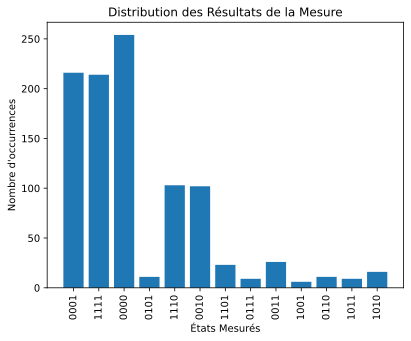

In [ ]:
import matplotlib.pyplot as plt

simulator = AerSimulator()
job = simulator.run(qc.decompose(reps=6), shots=1000)
job_result = job.result()

res = dict(job.result().get_counts(qc))

print(res)
# Exécuter la simulation
simulator = AerSimulator()
job = simulator.run(qc.decompose(reps=7), shots=1000)
job_result = job.result()

res = dict(job_result.get_counts(qc))

# Affichage des résultats dans la console
print("Résultats de mesure:", res)

# Tracer un histogramme avec matplotlib
labels, values = zip(*res.items())
indices = np.arange(len(labels))
plt.bar(indices, values, tick_label=labels)
plt.xlabel('États Mesurés')
plt.ylabel("Nombre d'occurrences")
plt.title('Distribution des Résultats de la Mesure')
plt.xticks(rotation=90)
plt.show()


### Q 3.2 Results

We get a distribution of résults in the form of a dictionary.
 - each key is morally a fraction $s/r$, for $r$ the order of $a$ mod $N$
 - it is only written with some precision (depending on the chosen number of bits), and it is written in binary.
 - The value associated to a key is the number of times we found the corresponding key.
 
Below is a code drawing a graph out of `d` with horizontal axis the key, in decimal, and in vertical axis the number of times we found it.

Résultats de mesure (décomposition 6): {'1100': 43, '0011': 47, '1110': 54, '0111': 150, '1001': 145, '1101': 58, '0000': 162, '1111': 20, '0100': 44, '0110': 45, '0001': 23, '0010': 75, '0101': 45, '1011': 45, '1010': 37, '1000': 7}
Résultats de mesure (décomposition 7): {'0010': 77, '1010': 47, '1001': 129, '1101': 58, '0111': 131, '0011': 60, '0101': 54, '0000': 161, '1100': 33, '1110': 81, '1000': 6, '0100': 41, '1011': 39, '0110': 37, '1111': 21, '0001': 25}


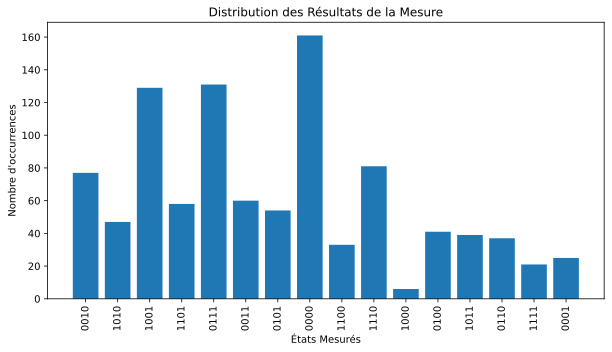

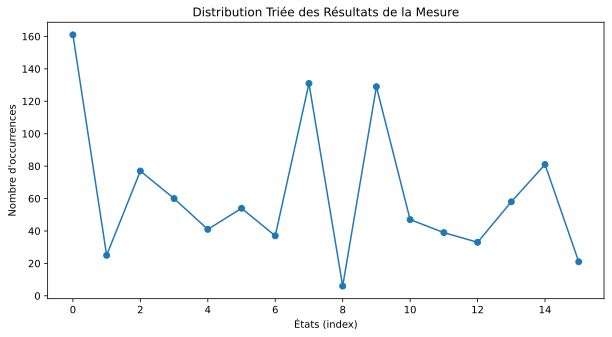

In [ ]:

size_eig = 4  

simulator = AerSimulator()
job = simulator.run(transpile(qc.decompose(reps=6), simulator), shots=1000)
job_result = job.result()
res = dict(job_result.get_counts(qc))

print("Résultats de mesure (décomposition 6):", res)

job = simulator.run(transpile(qc.decompose(reps=7), simulator), shots=1000)
job_result = job.result()
res = dict(job_result.get_counts(qc))

print("Résultats de mesure (décomposition 7):", res)

labels, values = zip(*res.items())
indices = np.arange(len(labels))
plt.figure(figsize=(10, 5))
plt.bar(indices, values, tick_label=labels)
plt.xlabel('États Mesurés')
plt.ylabel("Nombre d'occurrences")
plt.title('Distribution des Résultats de la Mesure')
plt.xticks(rotation=90)
plt.show()
pts = []
for i in range(2**size_eig):
    k = format(i, f'0{size_eig}b')  
    if k in res:
        pts.append((i, res[k]))
    else:
        pts.append((i, 0))

pts.sort(key=lambda a: a[0])
xs = [x for x, y in pts]
ys = [y for x, y in pts]

plt.figure(figsize=(10, 5))
plt.plot(xs, ys, marker='o')
plt.xlabel('États (index)')
plt.ylabel("Nombre d'occurrences")
plt.title('Distribution Triée des Résultats de la Mesure')
plt.show()

### Q 3.3 Analysis

- What is the order $r$ of $a$ mod $N$ (here $7$ mod $30$) ?
- On the drawing, where are we supposed to see the values $\frac{s}{r}$ ? The horizontal axis is graded with integers... To what real numbers between 0 and 1 these correspond to ?
- Can you infer from the graph the value of $r$ ? Where do you see it on the graph ?
- Change a and N respectively to 20 and 29. Can you read the value $r$ ? Is it correct ?
- The drawing is not very precise... How to make it better ? Try it !
- Is it still working if you change the value of `a` and/or `N` to other values ? Beware not to use too large values for`N`... To get some inspiration, below is the list of possibilities up to 31.

**BEWARE** Make sure to only consider coprimes `a` and `N`.

#### Report in the separate report:
* your code
* screenshots of circuits
* the results of your runs
* screenshots of plots 
* answers to questions and discussion


In [338]:
for N in range(3,32):
    for a in range(2,N):
        if gcd(a,N) == 1:
            for p in range(1,N):
                if (a ** p) % N == 1:
                    break
            print(f"Order of {a} mod {N}: {p}")

Order of 2 mod 3: 2
Order of 3 mod 4: 2
Order of 2 mod 5: 4
Order of 3 mod 5: 4
Order of 4 mod 5: 2
Order of 5 mod 6: 2
Order of 2 mod 7: 3
Order of 3 mod 7: 6
Order of 4 mod 7: 3
Order of 5 mod 7: 6
Order of 6 mod 7: 2
Order of 3 mod 8: 2
Order of 5 mod 8: 2
Order of 7 mod 8: 2
Order of 2 mod 9: 6
Order of 4 mod 9: 3
Order of 5 mod 9: 6
Order of 7 mod 9: 3
Order of 8 mod 9: 2
Order of 3 mod 10: 4
Order of 7 mod 10: 4
Order of 9 mod 10: 2
Order of 2 mod 11: 10
Order of 3 mod 11: 5
Order of 4 mod 11: 5
Order of 5 mod 11: 5
Order of 6 mod 11: 10
Order of 7 mod 11: 10
Order of 8 mod 11: 10
Order of 9 mod 11: 5
Order of 10 mod 11: 2
Order of 5 mod 12: 2
Order of 7 mod 12: 2
Order of 11 mod 12: 2
Order of 2 mod 13: 12
Order of 3 mod 13: 3
Order of 4 mod 13: 6
Order of 5 mod 13: 4
Order of 6 mod 13: 12
Order of 7 mod 13: 12
Order of 8 mod 13: 4
Order of 9 mod 13: 3
Order of 10 mod 13: 6
Order of 11 mod 13: 12
Order of 12 mod 13: 2
Order of 3 mod 14: 6
Order of 5 mod 14: 6
Order of 9 mod 14: 

Measurement results: {'01001': 9732, '11000': 419, '00110': 3354, '10111': 9938, '11101': 1134, '10110': 1453, '00000': 14336, '01101': 4415, '10011': 4382, '01111': 1960, '11001': 2820, '11100': 3240, '10010': 6248, '10101': 1306, '11011': 3467, '01100': 1565, '01110': 6232, '11010': 3206, '00011': 1065, '10100': 1505, '00101': 3410, '00010': 1731, '00100': 3100, '00111': 2770, '01010': 1313, '00001': 136, '10001': 1923, '01011': 1222, '11110': 1707, '01000': 355, '10000': 397, '11111': 159}


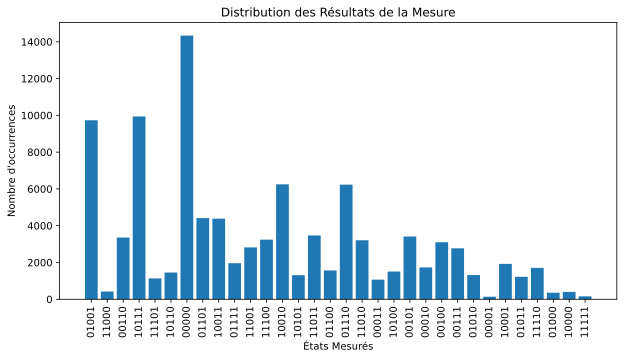

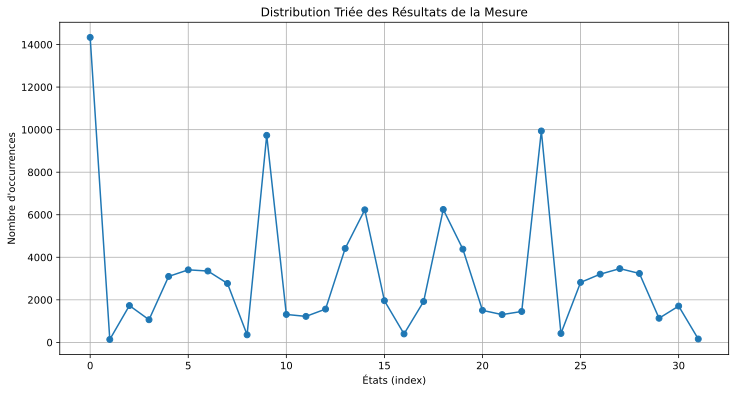

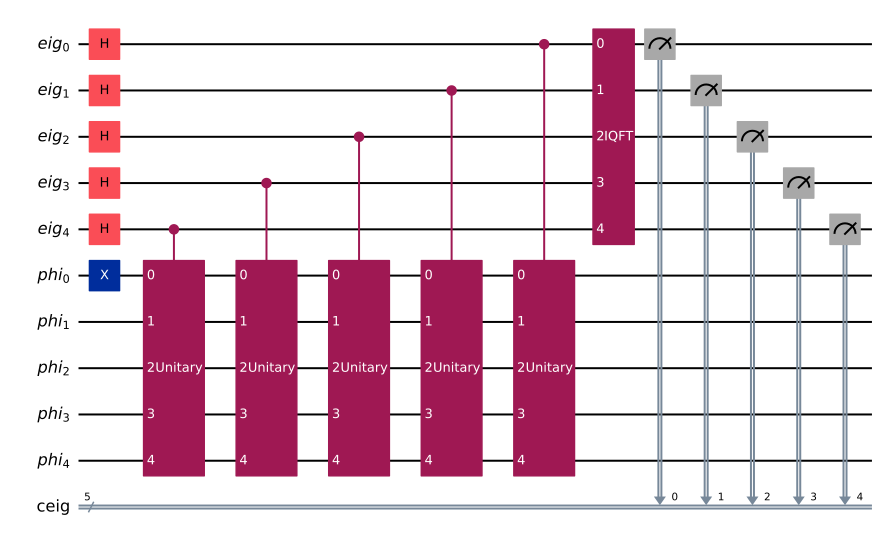

In [ ]:

a = 20   
p = 3   
N = 29  
n = 5    

size_eig = 5
eig = QuantumRegister(size_eig, name="eig")
phi = QuantumRegister(n, name="phi")  
ceig = ClassicalRegister(size_eig, name="ceig")
qc = QuantumCircuit(eig, phi, ceig)

qc.x(phi[0])  #  |00001> 
qc.h(eig)
for i in range(size_eig):
    power = 2 ** i  # U^1, U^2, U^4, U^8,
    controlled_mult_gate = gateMult(a, power, N, n).control(1)
    qc.append(controlled_mult_gate, [eig[size_eig - i - 1]] + list(phi))

qc.append(QFT(size_eig, inverse=True).to_gate(), eig)
qc.measure(eig, ceig)
qc.draw(output='mpl')

simulator = AerSimulator()
job = simulator.run(transpile(qc, simulator), shots=100000)  # Increased number of shots
job_result = job.result()
res = job_result.get_counts(qc)

print("Measurement results:", res)

labels, values = zip(*res.items())
indices = np.arange(len(labels))
plt.figure(figsize=(10, 5))
plt.bar(indices, values, tick_label=labels)
plt.xlabel('États Mesurés')
plt.ylabel("Nombre d'occurrences")
plt.title('Distribution des Résultats de la Mesure')
plt.xticks(rotation=90)
plt.show()

pts = []
for i in range(2**size_eig):
    k = format(i, f'0{size_eig}b')  
    if k in res:
        pts.append((i, res[k]))
    else:
        pts.append((i, 0))

pts.sort(key=lambda a: a[0])

xs = [x for x, y in pts]
ys = [y for x, y in pts]

plt.figure(figsize=(12, 6))
plt.plot(xs, ys, marker='o')
plt.xlabel('États (index)')
plt.ylabel("Nombre d'occurrences")
plt.title('Distribution Triée des Résultats de la Mesure')
plt.grid(True)
plt.show()
qc.draw(output='mpl')


Measurement results: {'1001010': 444, '1110100': 317, '0100111': 1309, '0111000': 186, '1001001': 6765, '0000000': 14500, '0110111': 6789, '1011010': 2031, '0010101': 176, '1011001': 1389, '0110011': 1202, '0101101': 816, '0110101': 785, '0101011': 62, '1101111': 1036, '0010011': 2198, '1010010': 1439, '0010110': 419, '1101100': 591, '0010000': 103, '1101110': 3329, '1001011': 772, '1110111': 378, '0111100': 86, '0100100': 2519, '0100101': 1785, '0111011': 980, '1110110': 386, '1001100': 334, '1100110': 805, '0010010': 3187, '0010001': 935, '1101101': 2220, '1101001': 1695, '1010011': 761, '0000111': 324, '0011010': 794, '1011100': 2536, '1110000': 130, '1001110': 796, '0100011': 476, '0111101': 287, '1000101': 929, '0011101': 263, '1101011': 192, '0010111': 1660, '1011110': 1056, '0100110': 2139, '0111010': 252, '0001111': 390, '0011000': 87, '0011011': 782, '1100111': 512, '1001101': 1223, '1110001': 389, '0111110': 20, '0100010': 974, '1100010': 545, '1111111': 20, '1000011': 309, '

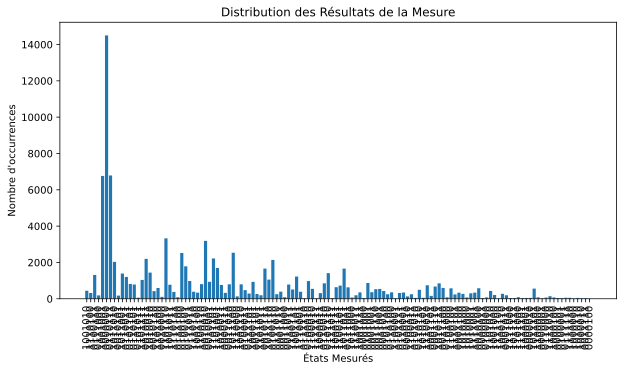

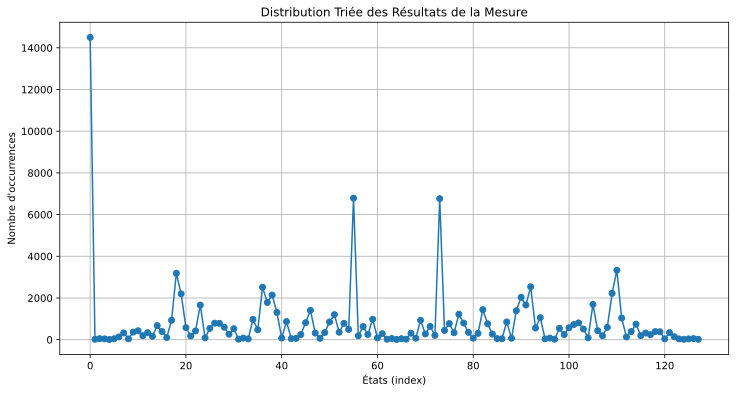

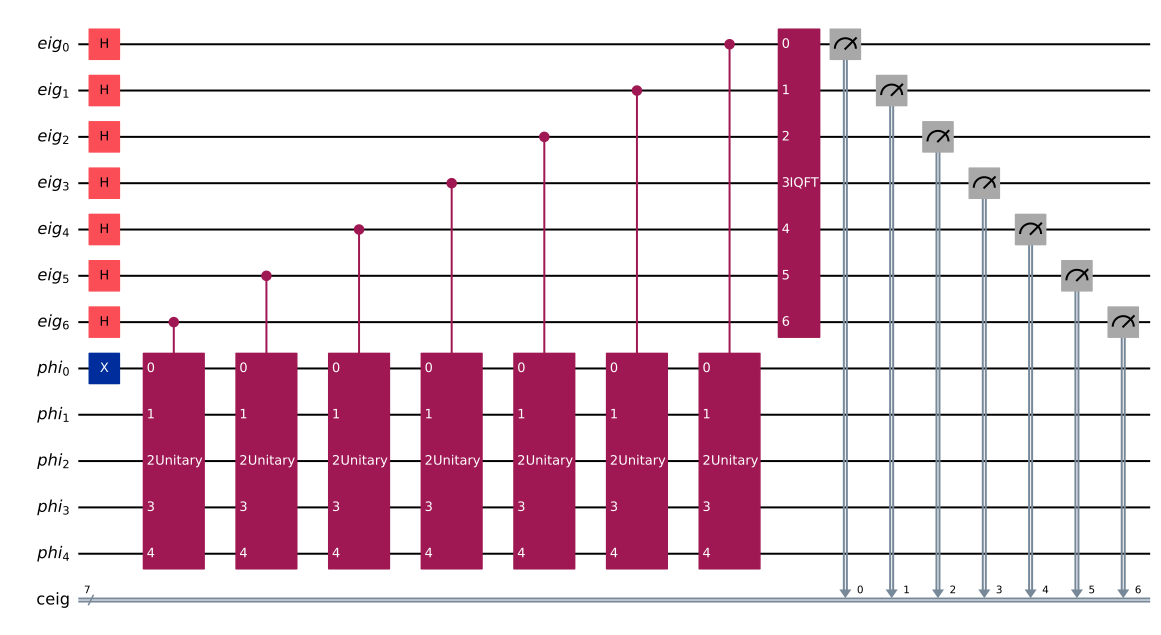

In [ ]:
a = 20   
p = 3    
N = 29   
n = 5    

size_eig = 7  
eig = QuantumRegister(size_eig, name="eig")
phi = QuantumRegister(n, name="phi")  
ceig = ClassicalRegister(size_eig, name="ceig")
qc = QuantumCircuit(eig, phi, ceig)

qc.x(phi[0])  
qc.h(eig)

for i in range(size_eig):
    power = 2 ** i  # U^1, U^2, U^4, U^8, 
    controlled_mult_gate = gateMult(a, power, N, n).control(1)
    qc.append(controlled_mult_gate, [eig[size_eig - i - 1]] + list(phi))

qc.append(QFT(size_eig, inverse=True).to_gate(), eig)
qc.measure(eig, ceig)
qc.draw(output='mpl')

simulator = AerSimulator()
job = simulator.run(transpile(qc, simulator), shots=100000)  
job_result = job.result()
res = job_result.get_counts(qc)

print("Measurement results:", res)

labels, values = zip(*res.items())
indices = np.arange(len(labels))
plt.figure(figsize=(10, 5))
plt.bar(indices, values, tick_label=labels)
plt.xlabel('États Mesurés')
plt.ylabel("Nombre d'occurrences")
plt.title('Distribution des Résultats de la Mesure')
plt.xticks(rotation=90)
plt.show()

pts = []
for i in range(2**size_eig):
    k = format(i, f'0{size_eig}b')  
    if k in res:
        pts.append((i, res[k]))
    else:
        pts.append((i, 0))

pts.sort(key=lambda a: a[0])
xs = [x for x, y in pts]
ys = [y for x, y in pts]

plt.figure(figsize=(12, 6))
plt.plot(xs, ys, marker='o')
plt.xlabel('États (index)')
plt.ylabel("Nombre d'occurrences")
plt.title('Distribution Triée des Résultats de la Mesure')
plt.grid(True)
plt.show()
qc.draw(output='mpl')